In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load TESS Dataset
paths = []
labels = []
for dirname, _, filenames in os.walk('../TESS data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())

print(labels[:5])
print('Dataset is Loaded')

['angry', 'angry', 'angry', 'angry', 'angry']
Dataset is Loaded


In [3]:
len(paths)

2800

In [4]:
## Create a dataframe
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,../TESS data\OAF_angry\OAF_back_angry.wav,angry
1,../TESS data\OAF_angry\OAF_bar_angry.wav,angry
2,../TESS data\OAF_angry\OAF_base_angry.wav,angry
3,../TESS data\OAF_angry\OAF_bath_angry.wav,angry
4,../TESS data\OAF_angry\OAF_bean_angry.wav,angry


In [5]:
df['label'].value_counts()

label
angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

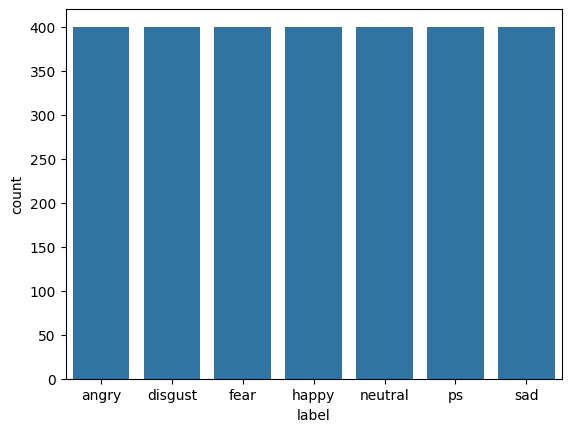

In [6]:
sns.countplot(data=df, x='label')

In [7]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

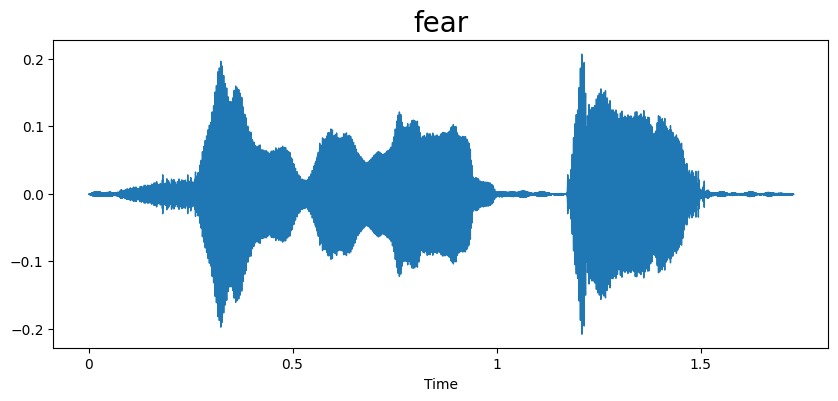

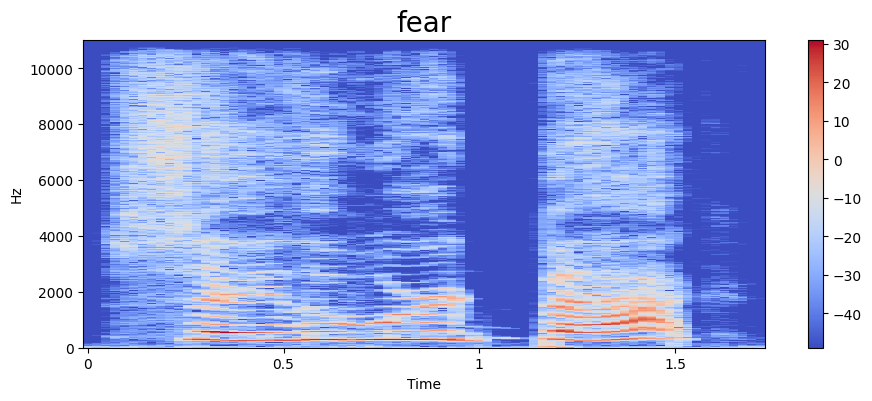

In [8]:
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [9]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [10]:
extract_mfcc(df['speech'][0])

array([-3.96986206e+02,  7.74405365e+01, -1.95927906e+01, -2.16666889e+01,
       -2.11275601e+00,  1.00753632e+01, -2.03667068e+01, -6.09244919e+00,
       -7.21228313e+00, -5.57366073e-01, -1.83255339e+00,  2.02101618e-01,
        7.27550924e-01,  1.31773746e+00,  2.88633800e+00,  2.85579062e+00,
       -4.71292210e+00, -4.43651056e+00, -1.62115955e+00, -1.02398405e+01,
       -7.55126143e+00, -1.79688025e+00, -7.03765249e+00,  9.43658352e+00,
        8.35585499e+00,  2.17123604e+01,  1.92169914e+01,  2.03489265e+01,
        1.34133663e+01,  8.33917236e+00,  3.94722193e-01,  5.11131477e+00,
        9.56873894e+00,  5.45486784e+00,  2.50996375e+00, -1.82390714e+00,
        4.86896229e+00,  9.31392288e+00,  2.08914971e+00, -1.90649164e+00],
      dtype=float32)

In [11]:
print(df.shape)

(2800, 2)


In [12]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [13]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(2800, 40)

In [14]:
## input split
X.shape

(2800, 40)

In [15]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [16]:
y = y.toarray()

In [17]:
y.shape

(2800, 7)

In [18]:
enc.categories_

[array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad'],
       dtype=object)]

In [19]:
# LSTM Model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten

model = Sequential([
    Dense(64, input_shape=(40,), activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,935 (19.28 KB)

 Trainable params: 4,935 (19.28 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the model
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

history = model.fit(X_train, y_train, epochs=300, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])
# history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1478 - loss: 46.1280 - val_accuracy: 0.2357 - val_loss: 3.2705
Epoch 2/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1826 - loss: 12.1405 - val_accuracy: 0.1304 - val_loss: 1.8801
Epoch 3/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1824 - loss: 4.1236 - val_accuracy: 0.1411 - val_loss: 1.9461
Epoch 4/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1634 - loss: 2.8623 - val_accuracy: 0.1393 - val_loss: 1.9471
Epoch 5/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1594 - loss: 2.4460 - val_accuracy: 0.1393 - val_loss: 1.9472
Epoch 6/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1785 - loss: 2.1968 - val_accuracy: 0.1393 - val_loss: 1.9473
Epoch 7/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1657 - loss: 2.1371 - val_accuracy: 0.1393 - val_loss: 1.9473
Epoch 8/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1553 - loss: 2.1229 - val_accuracy: 0.1393 -

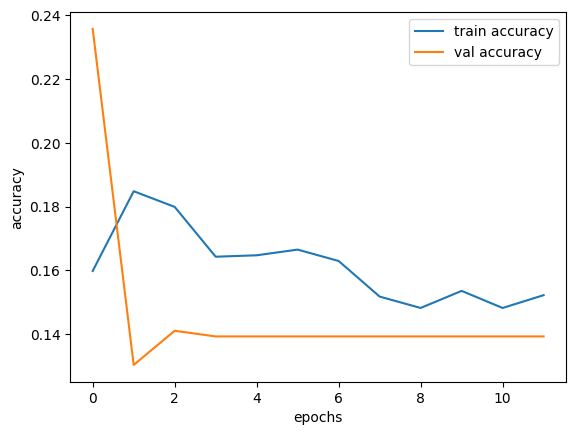

In [21]:
epochs = list(range(len(history.history['accuracy'])))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

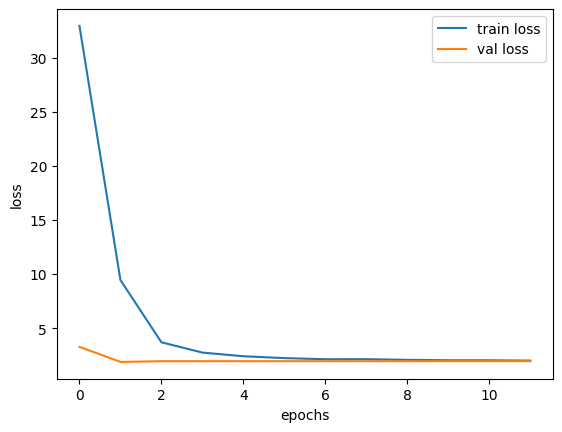

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [23]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

accuracy_score(y_true, y_pred), cm

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


(0.1392857142857143,
 array([[78,  0,  0,  0,  0,  0,  0],
        [90,  0,  0,  0,  0,  0,  0],
        [72,  0,  0,  0,  0,  0,  0],
        [89,  0,  0,  0,  0,  0,  0],
        [84,  0,  0,  0,  0,  0,  0],
        [68,  0,  0,  0,  0,  0,  0],
        [79,  0,  0,  0,  0,  0,  0]], dtype=int64))

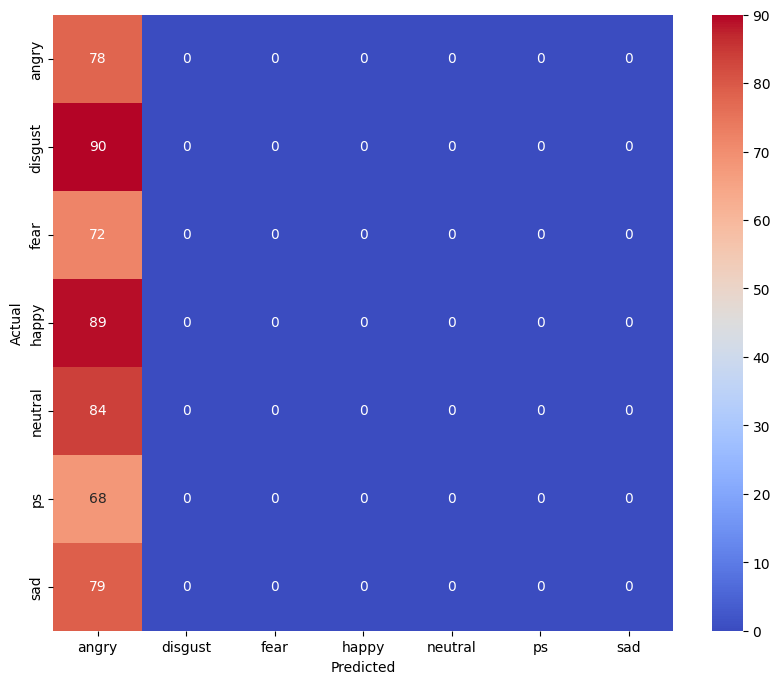

In [24]:
# print colorful confusion matrix
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=enc.categories_[0], yticklabels=enc.categories_[0])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


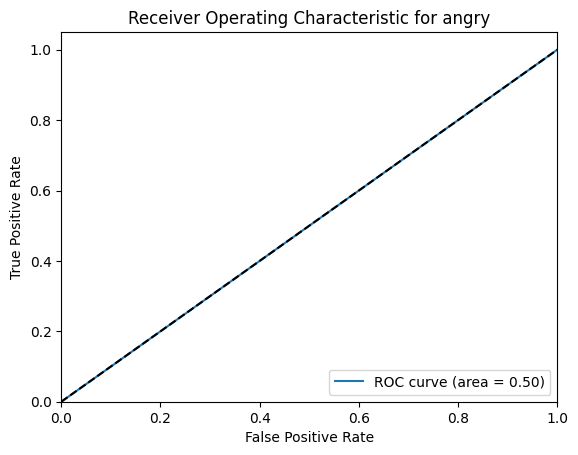

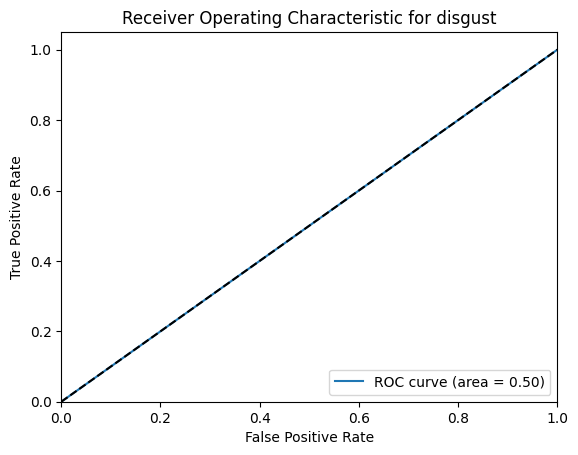

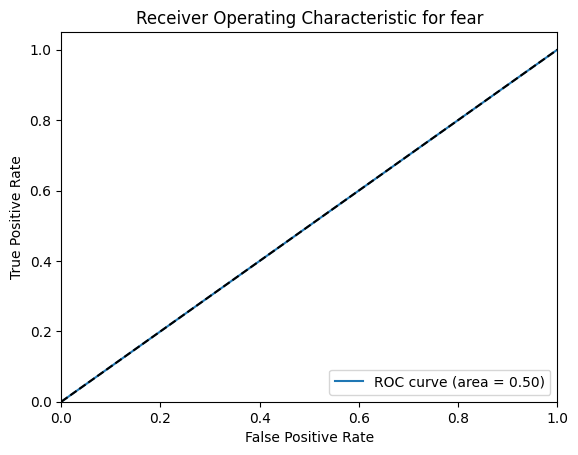

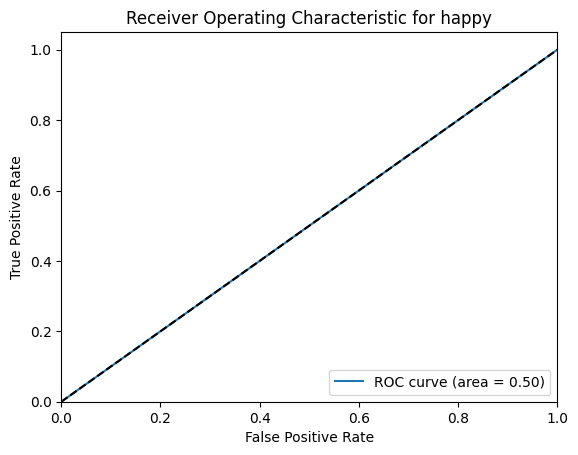

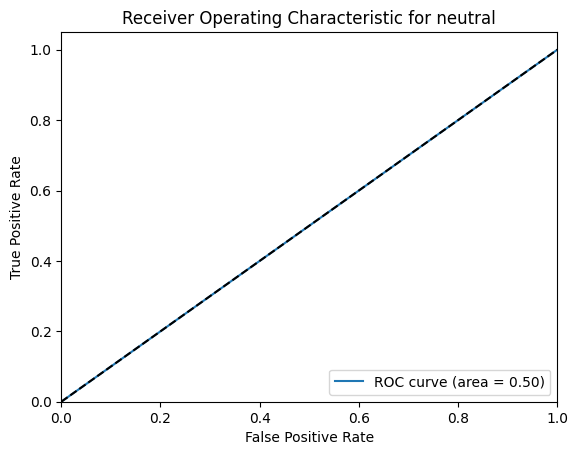

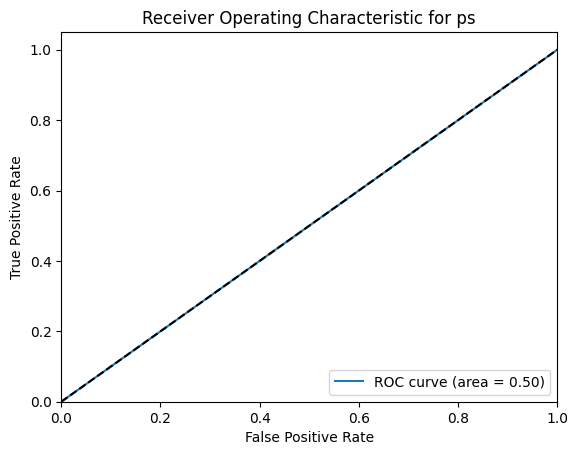

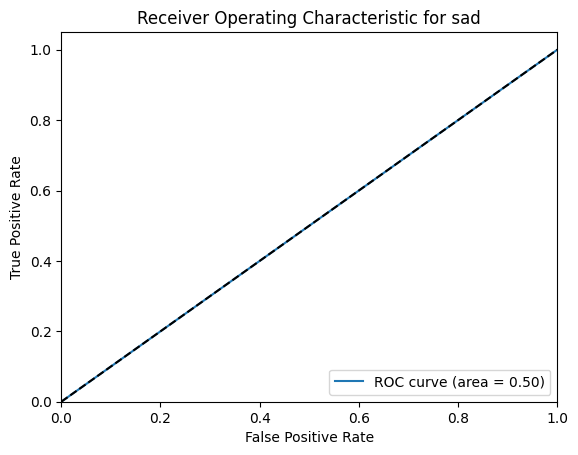

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

lb = LabelBinarizer()
y_test = lb.fit_transform(y_test)
y_pred = model.predict(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(7):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for '+enc.categories_[0][i])
    plt.legend(loc="lower right")
    plt.show()

In [26]:
#save model
model.save('..\Models\emotion_detection_TESS_MLP.keras')